In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev

import pycutest


from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from tqdm import tqdm

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../..")
from Functions import PyCutestWrapper, PyCutestGetter

In [5]:
def simplex_gradient(F, x_0, S, jrandom_key_f):
    num_func_calls = 0
    jrandom_key, subkey = jrandom.split(jrandom_key_f)
    FS = []
    for s_i in S.T:
        jrandom_key, subkey = jrandom.split(jrandom_key)
        FS.append(F.f(s_i + x_0, subkey))
        num_func_calls += 1
    FS = jnp.array(FS)
    jrandom_key, subkey = jrandom.split(jrandom_key)
    F_x_0 = F.f(x_0, subkey)
    num_func_calls += 1
    SS_inv = jnp.linalg.inv(S.dot(S.T))
    return SS_inv.dot(S.dot(FS - F_x_0)), num_func_calls




In [258]:

# eps = 0.1
sig = 0.01 # eps/jnp.sqrt(3)
eps = sig * jnp.sqrt(3)
noise_type = "uniform"
jrandom_key = jrandom.PRNGKey(0)



_, x_0, F = PyCutestGetter(4, eps, noise_type) # pycutest.import_problem("QUARTC")

coeff = .1 * len(x_0)
H = F.f2(x_0)



In [ ]:
def lambda_coeff_zero_set_max_lambda(D_diag, l_max, l_max_idx, sig):
    dim = len(D_diag)
    D_diag = jnp.abs(D_diag)
    D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_diag[l_max_idx])
    D_l_max_idx = D_diag[l_max_idx]

    D_l_max_idx * l_max + dim * ((-D_l_max_idx**3 * l_max**3))


    lmbdas = [(sig * jnp.sqrt(2*l/(D_diag[i] * a))) for i in range(len(D_diag))]
    lmbdas[jnp.argmin(jnp.abs(D_diag))] = l
    
    return jnp.array(lmbdas), [a, 0, l_max]

In [102]:


def helper_linesearch(f, g, c1, c2):

    def helper(X, search_direction):
        f0 = f(X)
        f1 = g(X)
        dg = jnp.inner(search_direction, f1)

        def armijo_rule(alpha):
            return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper


def loss_getter(dim, N, H, sig):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        return 1/4 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

    return helper

def optimize_uncentered_S(H, sig, max_steps=15, jrandom_key=None, x_curr=None):
    
    dim = H.shape[0]
    N = dim
    
    H = (H + H.T) / 2. # to combat numerical inaccuracies. 
    D, U = jnp.linalg.eig(H)
    U = jnp.real(U)

    # print("D", repr(jnp.real(D)))
#     D = jnp.abs(jnp.real(jnp.diag(D)))
    D = jnp.diag(D)

    if x_curr is None:

        if jrandom_key is None:
            x_curr = jnp.diag(jnp.sqrt(sig / jnp.abs(jnp.diag(D)))).flatten()
            pass
        else:
            x_curr = jrandom.normal(jrandom_key, shape=(dim * dim,)) * 0.1
        

    
    l = loss_getter(dim, N, D, sig)
    g_l = grad(l)
    h_l = jacfwd(g_l)
    linesearch = helper_linesearch(l, g_l, c1=0.1, c2=0.9)

    eps = 1e-20

    res = []
    res_x = []

    for t in tqdm(range(max_steps)):

        
        res.append(l(x_curr))
#         res_x.append(U.dot(x_curr.reshape(N, dim).T)) # TURN ON FOR HISTORY 

        curr_grad = g_l(x_curr)
#         print(curr_grad)
    
        # print(curr_grad)
#         curr_hess = h_l(x_curr) + 0.1*jnp.eye(dim**2)
#         search_direction = -jnp.linalg.inv(curr_hess) @ curr_grad #+ np.random.normal(size=(dim**2))*0.1
        search_direction = -curr_grad + np.random.normal(size=(dim * dim))*0.1

        if jnp.linalg.norm(curr_grad) < eps:
            break    

        alpha = linesearch(x_curr, search_direction)


        S = x_curr.reshape(N, dim).T

        SS = S.dot(S.T)

        x_curr += alpha*search_direction 
    
    return x_curr.reshape(N, dim).T, res

In [ ]:
l(jnp.diag([0.00519615]))

In [ ]:
0.69282, lm -> 0.00519615

In [103]:
jrandom_key = jrandom.PRNGKey(5)
# jrandom_key, subkey = jrandom.split(jrandom_key)

H = jnp.diag(jnp.array([100, 100]))

dim = len(H)

sig = 0.1

l = loss_getter(dim, dim, H, sig)
g_l = grad(l)
f2_l = jacfwd(g_l)

opt_S, l_hist = optimize_uncentered_S(H, sig=sig, max_steps=10, jrandom_key=jrandom_key, x_curr=opt_S.T.flatten())



100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


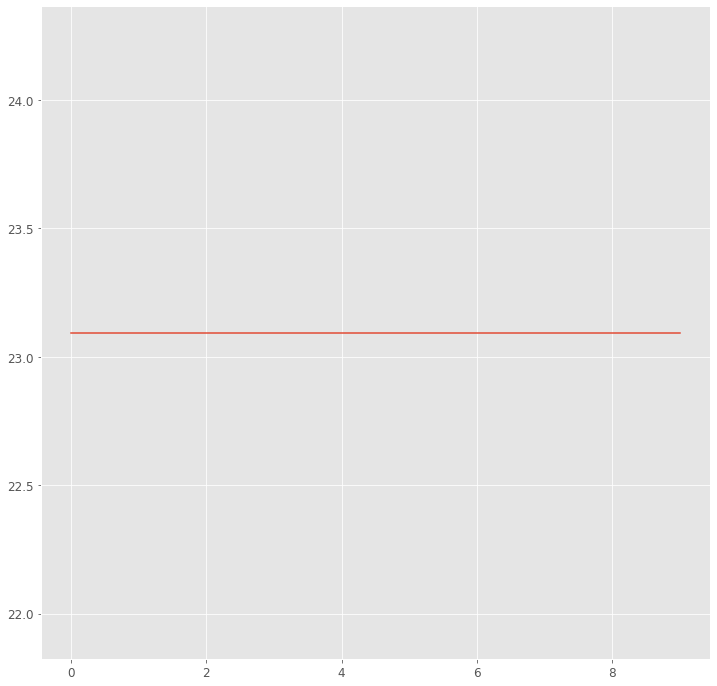

In [104]:
plt.plot(l_hist)

In [121]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-0.84517568,  0.5344886 ],
              [ 0.5344886 ,  0.84517568]], dtype=float64),
 DeviceArray([0.07208434, 0.04161791], dtype=float64),
 DeviceArray([[-0.70710678, -0.70710678],
              [ 0.70710678, -0.70710678]], dtype=float64))

In [123]:
(0.282843 / 100)**0.5

0.053182986001163945

In [122]:
0.00565685**0.5

0.0752120336116502

In [108]:
U, S, V = jnp.linalg.svd(opt_S)

In [126]:
g_l((U @ jnp.diag(S) @ V).T.flatten())

DeviceArray([-2.87627699e-11, -1.02318154e-12,  1.09707798e-11,
             -1.62572178e-11], dtype=float64)

In [127]:
g_l((jnp.diag(jnp.array([0.00565685**0.5, (0.282843 / 100)**0.5])) @ V).T.flatten())

DeviceArray([ 2.67337757e-04,  1.88030608e+02,  2.67337723e-04,
             -1.88030608e+02], dtype=float64)

In [125]:
l((jnp.diag(S) @ V).T.flatten())

DeviceArray(23.09401077, dtype=float64)

In [94]:
jnp.linalg.eigh(f2_l(opt_S.T.flatten()))

(DeviceArray([5.28709953e-12, 9.81649846e+03, 2.22222222e+04,
              3.01835015e+04], dtype=float64),
 DeviceArray([[ 0.02849136, -0.63080512, -0.70653255, -0.31950729],
              [ 0.70653255,  0.31950729,  0.02849136, -0.63080512],
              [ 0.62612081, -0.55905713,  0.32859204,  0.43296089],
              [ 0.32859204,  0.43296089, -0.62612081,  0.55905713]],            dtype=float64))

In [95]:
g_l(opt_S.T.flatten())

DeviceArray([ 0.00000000e+00,  3.37507799e-14, -2.84217094e-14,
             -2.27373675e-13], dtype=float64)

In [39]:
def lmbda_loss(lmbdas, D_diag, sig, coeff, l_max_idx):
    dim = len(D_diag)
    
    l_max = 1

    a = D_diag @ lmbdas / len(lmbdas)
    b = jnp.sum(lmbdas)
    lmbdas[0] = 1
    return 1/4 * a**2 * dim / lmbdas[l_max_idx] + sig**2 * dim/lmbdas[l_max_idx] + sig**2 * jnp.sum(1/lmbdas) + coeff*b**2

$\frac{\left(d \sqrt[3]{\frac{3 \sqrt{3} \sqrt{d} \sqrt{27 d \text{dSum}^4 l^2 \text{sig}^4-2 \text{dMin}^3 \text{dSum}^2 l^4 \text{sig}^2}+27 d \text{dSum}^2 l \text{sig}^2-\text{dMin}^3 l^3}{d^3}}+\text{dMin} l\right)^2}{3 d^2 \sqrt[3]{\frac{3 \sqrt{3} \sqrt{d} \sqrt{27 d \text{dSum}^4 l^2 \text{sig}^4-2 \text{dMin}^3 \text{dSum}^2 l^4 \text{sig}^2}+27 d \text{dSum}^2 l \text{sig}^2-\text{dMin}^3 l^3}{d^3}}}$

In [64]:
D_diag = jnp.linspace(1, 120, 8)

D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_diag[l_max_idx])
D_min = 1
dim = 8
sig = 0.6
l_max = 1

sqrt_term = 3 * jnp.sqrt(3 * dim) * jnp.sqrt(27 * dim * D_sum**4 * l_max**2 * sig**4 - 2 * D_min**3 * D_sum**2 * l_max**4 * sig**2)
cbrt_term = jnp.cbrt(sqrt_term + 27 * dim * D_sum**2 * l_max * sig**2 - D_min**3 * l_max**3)/dim

a = (dim * cbrt_term + D_min * l_max)**2 / (3 * dim**2 * cbrt_term)

lmbdas = [(sig * jnp.sqrt(2*l_max/(D_diag[i] * a))) for i in range(len(D_diag))]
lmbdas[jnp.argmin(jnp.abs(D_diag))] = l_max

jnp.array(lmbdas)



DeviceArray([1.        , 0.10901637, 0.07817969, 0.06413961, 0.05568054,
             0.04987452, 0.04557318, 0.04222186], dtype=float64)

In [49]:
import scipy
from jax import grad

In [54]:
def lmbda_loss(lmbdas, D_diag, sig, coeff, l_max_idx):
    dim = len(D_diag)
    
    l_max = 1

    a = (D_diag @ lmbdas - D_diag[0] * lmbdas[0] + l_max * D_diag[0] ) / len(lmbdas)

    return 1/4 * a**2 * dim / l_max + sig**2 * dim / l_max + sig**2 * jnp.sum(1/lmbdas[1:]) + sig**2 / l_max


In [65]:
# D_diag = jnp.linspace(1, 10, 8)

coeff = 0
x0 = jnp.ones(dim)

grad(lambda x: lmbda_loss(x, D_diag, sig, coeff, l_max_idx))(jnp.array(lmbdas))

DeviceArray([ 0.00000000e+00,  3.55271368e-15, -7.10542736e-15,
              1.42108547e-14, -2.84217094e-14,  2.84217094e-14,
              0.00000000e+00, -8.52651283e-14], dtype=float64)

In [21]:
D_diag = jnp.array([0.00000000e+00, 2.00000000e+00, 3.42398638e+00,
             1.06092485e+02, 1.06092485e+02, 1.06092485e+02,
             1.06092485e+02, 1.06092485e+02, 1.06092485e+02,
             1.06092485e+02, 1.06092485e+02, 1.06092485e+02,
             1.06092485e+02, 1.06092485e+02, 1.06092485e+02,
             1.06092485e+02, 2.74818379e+04, 2.74818379e+04,
             2.74818379e+04, 2.74818379e+04, 2.74818379e+04,
             2.74818379e+04, 2.74818379e+04, 2.74818379e+04,
             2.74818379e+04, 2.74818379e+04, 2.74818379e+04,
             2.74818379e+04, 2.74818379e+04, 2.74818379e+04,
             2.74818379e+04, 2.74818379e+04])

In [22]:
def lambda_coeff_zero_set_max_lambda(D_diag, l_max, sig):
    dim = len(D_diag)
    D_diag = jnp.abs(D_diag)
    D_min = jnp.min(D_diag)
    D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_min)

    sqrt_term = 3 * jnp.sqrt(3 * dim) * jnp.sqrt(27 * dim * D_sum**4 * l_max**2 * sig**4 - 2 * D_min**3 * D_sum**2 * l_max**4 * sig**2)
    cbrt_term = jnp.cbrt(sqrt_term + 27 * dim * D_sum**2 * l_max * sig**2 - D_min**3 * l_max**3)/dim

    a = (dim * cbrt_term + D_min * l_max)**2 / (3 * dim**2 * cbrt_term)
    
    lmbdas = []
    for i in range(len(D_diag)):
        if D_diag[i] != 0:
            lmbdas.append(min(sig * jnp.sqrt(2*l_max/(D_diag[i] * a)), l_max))
        else:
            lmbdas.append(l_max)
        
    lmbdas[jnp.argmin(D_diag)] = l_max
    
    
    
    return jnp.array(lmbdas)

In [24]:
def generate_sing_vals_V(D_diag, sig, max_h):
    dim = len(D_diag)
    lmbda = lambda_coeff_zero_set_max_lambda(D_diag, sig, 10)
    if jnp.max(lmbda) > max_h**2:
        lmbda = lambda_coeff_zero_set_max_lambda(D_diag, max_h**2, sig)

    if jnp.max(lmbda) > max_h**2:
        lmbda = max_h**2 * jnp.ones(dim)

    sing_vals = jnp.diag(lmbda**0.5)
    V = jnp.eye(dim)

    print(repr(D_diag))

    print(lmbda**0.5)
    
    return sing_vals, V


In [25]:
lambda_coeff_zero_set_max_lambda(D_diag, 0.5**2, 10)

DeviceArray([0.25      , 0.25      , 0.25      , 0.08066483, 0.08066483,
             0.08066483, 0.08066483, 0.08066483, 0.08066483, 0.08066483,
             0.08066483, 0.08066483, 0.08066483, 0.08066483, 0.08066483,
             0.08066483, 0.00501191, 0.00501191, 0.00501191, 0.00501191,
             0.00501191, 0.00501191, 0.00501191, 0.00501191, 0.00501191,
             0.00501191, 0.00501191, 0.00501191, 0.00501191, 0.00501191,
             0.00501191, 0.00501191], dtype=float64)

In [59]:
D_diag = jnp.linspace(1, 10, 8)

D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_diag[l_max_idx])
D_min = 1
dim = 8
sig = 0.1
l_max = 0.1

sqrt_term = 3 * jnp.sqrt(3 * dim) * jnp.sqrt(27 * dim * D_sum**4 * l_max**2 * sig**4 - 2 * D_min**3 * D_sum**2 * l_max**4 * sig**2)
cbrt_term = jnp.cbrt(sqrt_term + 27 * dim * D_sum**2 * l_max * sig**2 - D_min**3 * l_max**3)/dim

a = (dim * cbrt_term + D_min * l_max)**2 / (3 * dim**2 * cbrt_term)

lmbdas = [(sig * jnp.sqrt(2*l_max/(D_diag[i] * a))) for i in range(len(D_diag))]
lmbdas[jnp.argmin(jnp.abs(D_diag))] = l_max

lmbdas




[0.1,
 DeviceArray(0.06364063, dtype=float64),
 DeviceArray(0.0509125, dtype=float64),
 DeviceArray(0.04365711, dtype=float64),
 DeviceArray(0.03882042, dtype=float64),
 DeviceArray(0.03530147, dtype=float64),
 DeviceArray(0.03259339, dtype=float64),
 DeviceArray(0.03042604, dtype=float64)]

In [29]:
def lambda_coeff_zero(D_diag, l_max_idx, sig):
    dim = len(D_diag)
    D_diag = jnp.abs(D_diag)
    D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_diag[l_max_idx])
    D_l_max_idx = D_diag[l_max_idx]
    numerator = 2 * (1 + dim) * D_l_max_idx * sig**2 + D_sum**2 * sig**2 + jnp.sqrt(D_sum**2 * (8 * (1 + dim) * D_l_max_idx + D_sum**2) * sig**4)
    
    a = jnp.sqrt(2 * numerator/(dim * D_l_max_idx))
    l = (2 * (1 + dim) * D_l_max_idx * sig**2 + numerator)/(D_l_max_idx**2 * a)

    lmbdas = [(sig * jnp.sqrt(2*l/(D_diag[i] * a))) for i in range(len(D_diag))]
    lmbdas[jnp.argmin(jnp.abs(D_diag))] = l
    
    return jnp.array(lmbdas), [a, 0, l]


lambda_coeff_zero(D_diag, 0, sig)

(DeviceArray([5.14329454, 0.18975851, 0.15180681, 0.13017327, 0.11575161,
              0.10525908, 0.09718435, 0.09072192], dtype=float64),
 [DeviceArray(1.2498184, dtype=float64),
  0,
  DeviceArray(5.14329454, dtype=float64)])

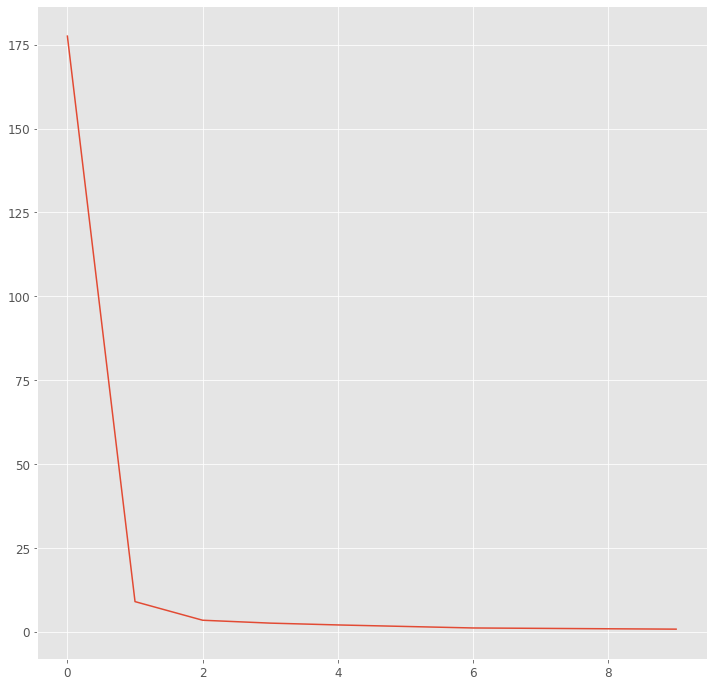

In [11]:
plt.plot(l_hist)

In [12]:
g_l(opt_S.T.flatten())

DeviceArray([-0.52296128,  0.22943354, -0.3531154 ,  1.11570721,
             -0.90322739,  0.20856244, -2.11594852,  0.31786149,
             -2.06394907,  2.25483303,  0.21091912, -0.07047817,
             -0.10676361,  0.79200935, -0.14500933, -0.44771145,
              2.26412436, -2.42588899, -1.97268315,  5.22494019,
             -0.60532069, -0.18773841, -0.7728482 ,  1.91589632,
             -2.0359586 ], dtype=float64)

In [9]:
jnp.linalg.eig(jacfwd(g_l)(opt_S.T.flatten()))

[DeviceArray([ 2.11206096e+02+0.j,  1.91813110e+02+0.j,
               1.36021935e+02+0.j,  8.06275795e+01+0.j,
               7.92992130e+00+0.j,  8.55326280e-01+0.j,
              -4.05621394e-03+0.j,  1.56153062e-01+0.j,
               5.70469092e+01+0.j,  2.70548441e+01+0.j,
               3.52484843e+01+0.j,  4.48723902e+01+0.j,
               4.25669247e+01+0.j,  4.15451327e+01+0.j,
               3.89926980e+01+0.j,  3.93534169e+01+0.j], dtype=complex128),
 DeviceArray([[ 1.76963147e-01+0.j,  4.78909259e-01+0.j,
               -2.82689285e-01+0.j, -1.29173361e-01+0.j,
                7.95077501e-02+0.j, -1.83214822e-01+0.j,
                3.42330428e-01+0.j, -1.32387667e-01+0.j,
                2.62102954e-01+0.j,  6.16205626e-02+0.j,
               -2.30899931e-01+0.j, -2.96435896e-01+0.j,
               -4.01765680e-01+0.j,  1.83780117e-01+0.j,
                2.40644586e-01+0.j, -3.66132205e-02+0.j],
              [ 8.39539792e-02+0.j,  2.66995505e-01+0.j,
               -1.

In [547]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-3.43269255e-01,  3.28351735e-01,  8.23266701e-01,
               -3.10778532e-01],
              [-1.57669635e-01, -9.43711408e-01,  2.75127097e-01,
               -9.40964692e-02],
              [-9.03379783e-01,  3.99238178e-02, -2.66735445e-01,
                3.33411547e-01],
              [-2.03006090e-01,  7.49105358e-05, -4.18794965e-01,
               -8.85098469e-01]], dtype=float64),
 DeviceArray([1.01096617, 0.67607382, 0.67607382, 0.67607382], dtype=float64),
 DeviceArray([[-0.5       , -0.5       , -0.5       , -0.5       ],
              [ 0.04600649, -0.20940294,  0.76751329, -0.60411684],
              [ 0.25763312,  0.67422047, -0.31613296, -0.61572063],
              [-0.82553533,  0.50157469,  0.24694797,  0.07701267]],            dtype=float64))

In [196]:
jnp.diag(opt_S.T @ D @ opt_S)

DeviceArray([0.14260624, 0.14260624, 0.14260624, 0.14260624, 0.14260624,
             0.14260624], dtype=float64)

In [36]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-0.51204034, -0.30460385, -0.55900857, -0.57666334],
              [-0.47424182,  0.85747832,  0.1264342 , -0.15440214],
              [-0.69850683, -0.39047352,  0.47507435,  0.36595491],
              [-0.15810626,  0.1395631 , -0.66770366,  0.71393023]],            dtype=float64),
 DeviceArray([1.01096617, 0.67607382, 0.67607382, 0.67607382], dtype=float64),
 DeviceArray([[-0.5       , -0.5       , -0.5       , -0.5       ],
              [ 0.42729776,  0.04620924, -0.82970244,  0.35619544],
              [-0.75197927,  0.31141208, -0.12648721,  0.56705439],
              [ 0.04408868, -0.80677582,  0.21352949,  0.54915765]],            dtype=float64))

In [44]:
opt_S_V, opt_S_sing_vals, opt_S_U = jnp.linalg.svd(opt_S)

In [195]:
def set_loss(F, x_0, H, sig, coeff, num_runs):
    g_F = F.f1(x_0)
    def helper(S, jrandom_key):
        errs = []
        for _ in range(num_runs):
            jrandom_key, subkey = jrandom.split(jrandom_key)
            sgd = simplex_gradient(F, x_0, S, subkey)[0]
            errs.append(float(jnp.linalg.norm(sgd - g_F)**2))
        errs = jnp.array(errs)
        return jnp.mean(errs)
    return helper

In [244]:
mc_l = set_loss(F, x_0, H, sig, coeff, num_runs=50)

In [251]:
trial_S = jnp.eye(dim) * 0.0005

In [252]:
mc_l(trial_S, jrandom_key)

DeviceArray(77034.30935475, dtype=float64)

In [260]:
mc_l(pow_S, jrandom_key)

DeviceArray(165.06548232, dtype=float64)

In [201]:
jnp.linalg.eigh(H)

(DeviceArray([  -5.08353094,    4.57266158,   11.49318782,  170.32038347,
              1233.49134915], dtype=float64),
 DeviceArray([[-0.56782602,  0.12077836,  0.71701966,  0.38387151,
               -0.03888029],
              [-0.32845181,  0.85098683, -0.40883139,  0.00728071,
               -0.02728919],
              [ 0.69297634,  0.50838248,  0.50305692, -0.0790808 ,
               -0.04484431],
              [-0.09747424, -0.0434688 ,  0.04527115, -0.31062402,
               -0.94343653],
              [ 0.28279955, -0.02986163, -0.2522379 ,  0.86593799,
               -0.32505404]], dtype=float64))

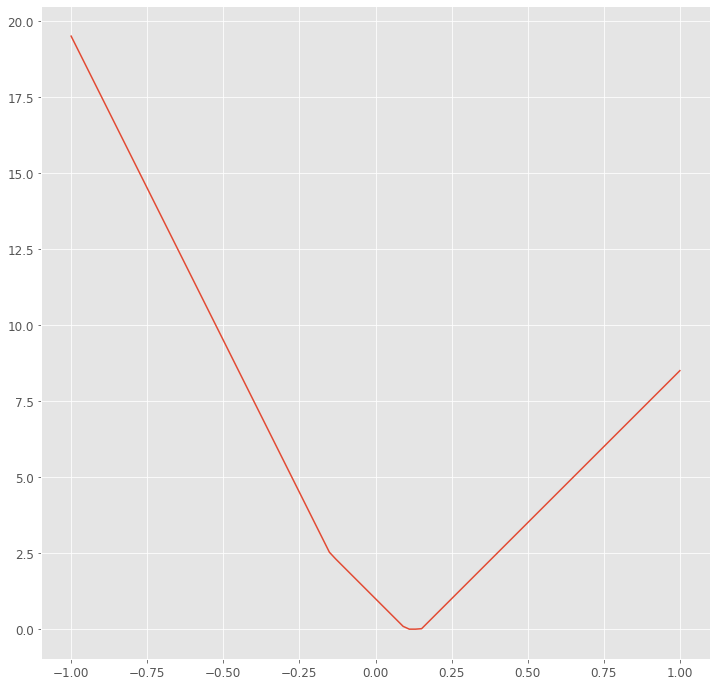

In [152]:

def hinge_loss(data, thresh):
    l = 0
    for d in data:
        y = -thresh + d[0]
#         print(y)
        l += max(0, 1 - 10* y * d[1])
    return l

bs = np.linspace(-1, 1, 100)
data = [[-0.25, -1], [0, -1], [0.25, 1]]

# print(hinge_loss(data, 0.26))
# print()
# print(hinge_loss(data, 0.24))


ys = [hinge_loss(data, b) for b  in bs]
plt.plot(bs, ys)
    
